# K Nearest Neighbors Classification

## 1. Introdução e Objetivo

### Classificação de Imagens com KNN
Este notebook analisa o dataset CIFAR-10 utilizando o algoritmo K-Nearest Neighbors (KNN) implementado manualmente.

#### Objetivo: 
Identificar o impacto do hiperparâmetro $K$ na acurácia do modelo através de validação cruzada.

## 2. Configuração e Carregamento de Dados

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage import exposure

# Funções de carregamento da base de dados CIFAR-10
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def ler_cifar(path, batch):
# ##################################    
# ler_cifar importa as imagens da base de dados CIFAR 10 
# Argumentos:
# path -- caminho que leva ao diretório da base de dados
# batch -- A base de dados contém 50 mil imagens divididas em 5 minibatches (lotes),
# este argumento é um escalar e define quantos minibatches serão importados. 
## Retorna: 
# X -- Uma matriz de tamanho (N, M) onde N é o número de imagens e M o tamanho da imagem vetorizada
# Y -- Um vetor 1D de tamanho (N, 1) que contém a classificação correta para cada imagem
# ##################################    

    X = np.empty((0,3072))
    Y = np.empty((1,0),dtype=int)
    if batch == 1:
        
        file = path + "\\data_batch_" + str(batch)
        
        dictionary = unpickle(file)
        X = dictionary[b'data']
        Y = np.asarray(dictionary[b'labels'])
            
    else:
            for i in range(1,batch+1):
                 file = path + "\\data_batch_" + str(i)        
                 dictionary = unpickle(file)
                 X = np.vstack([X,dictionary[b'data']])
                 temp = np.asarray(dictionary[b'labels'])
                 Y = np.append(Y,temp)
                
                 
    X = np.float32(X)   
    return X, Y

# Exemplo de visualização inicial
# X_raw, Y_raw = lecture_cifar(path, 1)
# print(f"Dataset carregado: {X_raw.shape[0]} imagens.")

path = r"C:\Users\caiqu\Desktop\Data Science\AI Classification Problem\cifar-10-batches-py"
batch = 1

X,Y = ler_cifar(path,batch)


C:\Users\caiqu\AppData\Local\Temp\ipykernel_11748\3169407351.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding='bytes')


In [2]:
def unflatten_image(img_flat):
# ##################################
# unflatten_image reconstrói a imagem obtida da base de dados CIFAR.
# Argumentos:
# img_flat -- Vetor de tamanho (1, 3072), uma imagem RGB vetorizada da base CIFAR
# Retorna:
# img -- Uma imagem de tamanho (32, 32, 3) pixels em RGB.
# ##################################
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img   


## 4. O Algoritmo KNN "From Scratch"
Implementamos a classe KPPV para calcular as distâncias e realizar a predição. A distância Euclidiana foi vetorizada para performance utilizando a fórmula:$$(A-B)^2 = A^2 - 2AB + B^2$$

In [3]:
class KPPV:
    
    def __init__(self):
        self.Acc = [] # Lista de acurácia (Accuracy)
        
    def distances(self,Xtest,Xapp):
    
        ## kppv_distances recebe como argumento Xtest e Xapp e
        ## retorna a matriz de distâncias Dist
            
        Xapp_squared = np.square(Xapp)
        Xtest_squared = np.square(Xtest)
        
        # Cálculo otimizado da distância Euclidiana: (A-B)^2 = A^2 - 2AB + B^2
        threeSums = np.sum(Xtest_squared[:,np.newaxis,:], axis=2) - 2 * Xtest.dot(Xapp.T) + np.sum(Xapp_squared, axis=1)
        Dist = np.sqrt(threeSums)
        
        return Dist
    
    def predict(self,Dist,Yapp,K):
        
     ## kppv_predict recebe como argumento Dist, Yapp e K (número de vizinhos)
        
        Yapp = np.transpose(Yapp)
        index = np.argpartition(Dist,K,axis=-1)[:,0:K]
        Ytemp = Yapp[index[:,:],0]
        
        num_rows = np.shape(Ytemp)[0]
        Ypred = np.zeros((num_rows,1))
        
        for i in range(num_rows):
                # Atribui a classe mais frequente entre os vizinhos (votação majoritária)
                Ypred[i] = np.argmax(np.bincount(Ytemp[i,:]))
    
        Ypred = Ypred.astype(int)
        Ypred = np.transpose(Ypred)
        return Ypred
    
    ## avaliacao_classificador recebe como argumento Ytest e Ypred e
    ## retorna a taxa de acerto (Acurácia).
    
    def avaliacao_classificador(self,Ytest,Ypred):
        
        Accuracy =  np.sum(Ypred == Ytest)/Ytest.size
        
        return Accuracy
    
kppv = KPPV()

## 5. Validação Cruzada (N-Fold) e Resultados
Para garantir que o modelo seja generalista, dividimos os dados em $N$ dobras. Testamos valores de $K$ ímpares para evitar empates na votação.

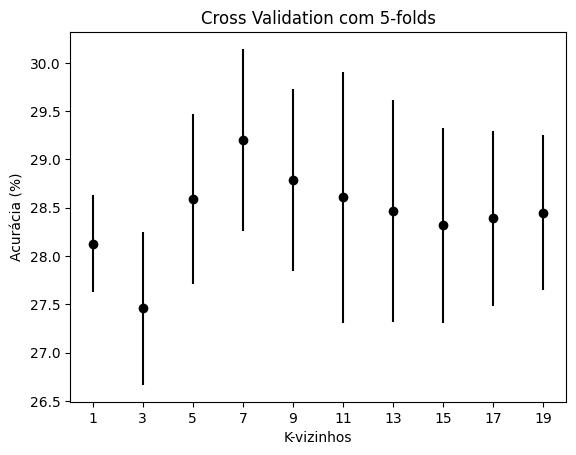

In [4]:
def Nfold_data(X,Y,N):
# ##################################    
# Nfold_data divide os dados em N dobras (folds)
# Argumentos : 
# X -- Uma matriz de tamanho (N_img, M) onde N_img é o número de imagens e M o tamanho da imagem vetorizada
# Y -- Um vetor 1D de tamanho (N_img, 1) que contém a classificação correta para cada imagem 
## Retorna: 
# Xapp, Xtest -- Uma matriz de tamanho (N, x, x) onde as duas primeiras dimensões são usadas para
# armazenar todos os dados da respectiva dobra indicada pela terceira dimensão.
# Yapp, Ytest -- Uma matriz de tamanho (N, 1, x) onde as duas primeiras dimensões são usadas para
# armazenar a classificação dos dados para a respectiva dobra indicada pela terceira dimensão.
# ##################################
 
    
    NX = np.split(X,N,0)
    NY = np.split(Y,N,0)
    
    NXnum_rows,NXnum_col = np.shape(NX[0])
    NYnum_rows,NYnum_col = np.shape(NY)
    
    Xapp = np.empty((N,NXnum_rows*(N-1),NXnum_col))
    Yapp = np.empty((N,1,NYnum_col*(N-1)),dtype=int)
    
    Xtest = np.empty((N,NXnum_rows,NXnum_col))
    Ytest = np.empty((N,1,NYnum_col),dtype=int)
    
    for i in range(N):
        
        tempX = np.roll(NX,-i,axis=0)
        tempY = np.roll(NY,-i,axis=0)
        Xtest[i] = tempX[0]
        Ytest[i] = tempY[0]      
            
        Xapp[i] = np.vstack(tempX[1:])      
        Yapp[i] = np.concatenate(tempY[1:,:]) 
             
             

    return Xapp,Yapp,Xtest,Ytest

K = 3 # Número de vizinhos 
N = 5 # Número de dobras (Nfold)

Xapp_fold,Yapp_fold,Xtest_fold,Ytest_fold = Nfold_data(X,Y,N)

Acc_Nfold= np.empty(N)
Acc = []
e = []

# Testando valores de K de 1 a 19 (apenas ímpares para evitar empates)
for K in range(1,21,2):    
    for i in range(N):
        
        Dist = kppv.distances(Xtest_fold[i],Xapp_fold[i])
        
        Ypred = kppv.predict(Dist,Yapp_fold[i],K)
        
        Acc_Nfold[i] = kppv.avaliacao_classificador(Ytest_fold[i],Ypred)
        
    
    Acc.append(np.mean(Acc_Nfold))
    e.append(np.std(Acc_Nfold))

#convertendo lista em np.array
Acc_np = np.array(Acc)
e_np = np.array(e)

# Plotagem do gráfico de Cross Validation
plt.errorbar(range(1,21,2),Acc_np*100,yerr=e_np * 100,fmt='ko')
plt.title(f"Cross Validation com {N}-folds")
plt.ylabel('Acurácia (%)')
plt.xlabel('K-vizinhos')
plt.xticks(np.arange(1,21,2))

plt.show()

## 6. Conclusão
O gráfico mostra que o valor ideal de $K$ é aproximadamente $7$, onde a acurácia atinge o pico por volta de 29%. Entretanto, observou-se uma baixa variância na acurácia para diferentes valores de K. Este fenômeno sugere que a separabilidade das classes no espaço de características HOG é limitada pela sobreposição inerente das classes do CIFAR-10, bem como pela maldição da dimensionalidade, onde a distância euclidiana em 1024 dimensões tende a se tornar uniforme. Além disso, o KNN possui complexidade $O(N \cdot D)$, tornando a predição lenta em datasets massivos. Portanto, para este tipo de problema o KNN não é uma ferramenta adequada.